In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchrl
import matplotlib.pyplot as plt
from tensordict import TensorDict
from flipper_training.environment.env import Env
from flipper_training.configs import *
from flipper_training.rl_objectives import *

In [11]:
num_robots = 2

In [12]:
from flipper_training.utils.heightmap_generators import *

# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 3.2  # meters
heighmap_gen = MultiGaussianHeightmapGenerator(
    min_gaussians=400,
    max_gaussians=600,
    min_height_fraction=0.03,
    max_height_fraction=0.12,
    min_std_fraction=0.03,
    max_std_fraction=0.08,
    min_sigma_ratio=0.6,
)
x_grid, y_grid, z_grid, suit_mask = heighmap_gen(grid_res, max_coord, num_robots)

In [13]:
from flipper_training.vis.static_vis import plot_heightmap_3d

plot_heightmap_3d(x_grid[0], y_grid[0], z_grid[0])

In [14]:
device = "cpu"

In [15]:
# Instatiate the physics config
robot_model = RobotModelConfig(kind="marv", points_per_driving_part=256, points_per_body=512)
world_config = WorldConfig(
    x_grid=x_grid,
    y_grid=y_grid,
    z_grid=z_grid,
    grid_res=grid_res,
    max_coord=max_coord,
    k_stiffness=40000,
    suitable_mask=suit_mask,
    k_friction_lat=0.5,
    k_friction_lon=1.0,
)
physics_config = PhysicsEngineConfig(num_robots=num_robots, damping_alpha=4.0)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_0.010_dp256b_512_whl0.02_trck0.05_6b5c78e6921a37db7bf931f0d2244c93f70b92b02a9b9262da081e7cfc4ab154
driving_direction: torch.Size([3])
body_bbox: torch.Size([6])
driving_part_bboxes: torch.Size([4, 6])
driving_part_masses: torch.Size([4])
joint_positions: torch.Size([4, 3])
joint_limits: torch.Size([2, 4])
joint_max_pivot_vels: torch.Size([4])
driving_part_movable_mask: torch.Size([4])
driving_part_points: torch.Size([4, 256, 3])
driving_part_inertias: torch.Size([4, 3, 3])
driving_part_cogs: torch.Size([4, 3])
body_points: torch.Size([512, 3])
body_inertia: torch.Size([3, 3])
body_cog: torch.Size([3])
thrust_directions: torch.Size([4, 256, 3])
joint_local_driving_part_pts: torch.Size([4, 256, 3])
joint_local_driving_part_cogs: torch.Size([4, 3])
RobotModelConfig for marv
Body mass: 47.8
Total mass: 67.8
Body bbox: tensor([ 0.3000,  0.1900,  0.4500, -0.3000, -0.1900, -0.0500])
N

In [16]:
from flipper_training.observations import *
from functools import partial

obs = {
    "perception": partial(Heightmap, percep_shape=(128, 128), percep_extent=(1.0, 1.0, -1.0, -1.0)),
    "observation": partial(RobotStateVector),
}

obs["perception"]

functools.partial(<class 'flipper_training.observations.heightmap.Heightmap'>, percep_shape=(128, 128), percep_extent=(1.0, 1.0, -1.0, -1.0))

In [17]:
from flipper_training.rl_rewards.rewards import *

reward = RollPitchGoal(1000, -1000, 1.0, 1.0)

In [18]:
objective = SimpleStabilizationObjective(
    physics_config=physics_config,
    robot_model=robot_model,
    world_config=world_config,
    device=device,
    rng=torch.manual_seed(0),
    **{
        "higher_allowed": 0.5,
        "min_dist_to_goal": 0.5,
        "max_dist_to_goal": 0.8,
        "start_drop": 1.5,
        "iteration_limit_factor": 10,
        "start_position_orientation": "towards_goal",
        "goal_reached_threshold": 0.05,
        "max_feasible_roll": torch.deg2rad(torch.tensor(70.0)),
        "cache_size": 10000,
    },
)

Initializing start/goal position cache: 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


In [19]:
torch_env = Env(objective, reward, obs, world_config, physics_config, robot_model, device, differentiable=False, batch_size=[num_robots])

In [20]:
torchrl.envs.utils.check_env_specs(torch_env)

2025-03-24 15:40:35,238 [torchrl][INFO] check_env_specs succeeded!


In [21]:
torch_env.visualize_curr_state()

In [22]:
from collections import deque
from flipper_training.engine.engine_state import vectorize_iter_of_states

In [23]:
ROBOT_IDX = 0

In [24]:
import time

Simulation time: 3.64881 seconds (0.00730 seconds per step)


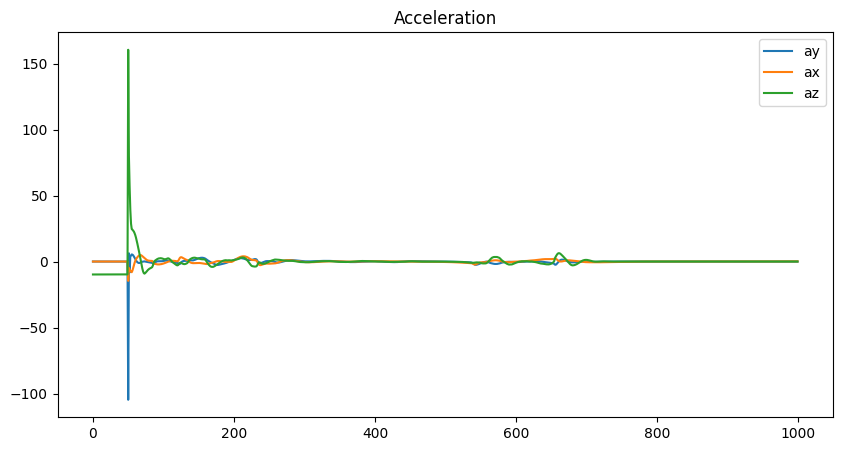

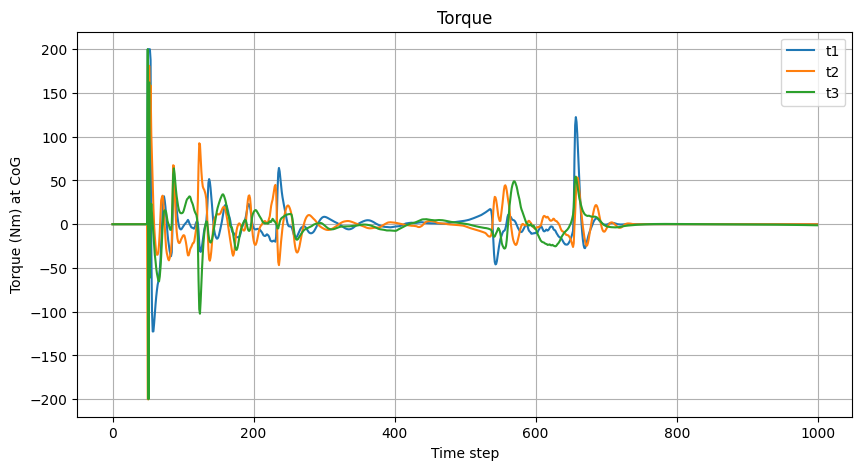

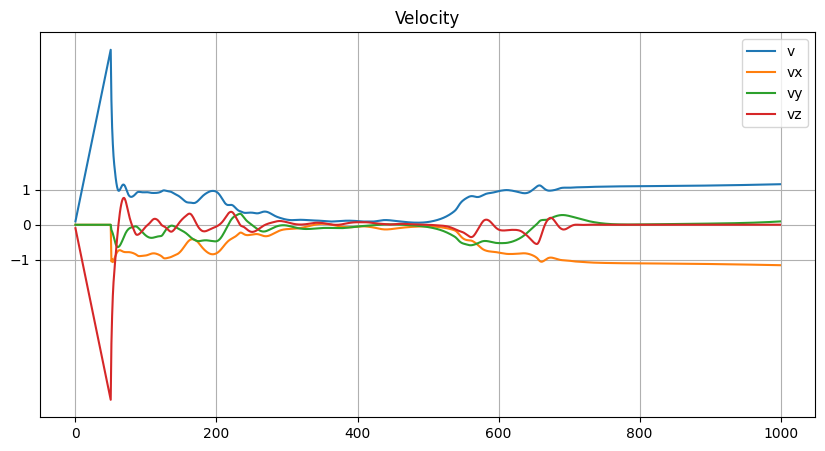

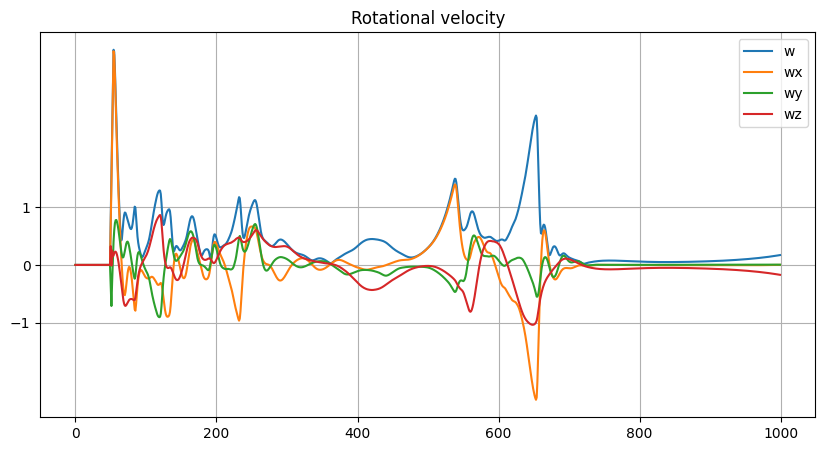

In [25]:
states = deque()
dstates = deque()
auxs = deque()

# Controls
speed = 1.0  # m/s forward
flipper_controls = torch.full((robot_model.num_driving_parts,), 0.0)
control_vec = torch.cat([torch.full((4,), speed), flipper_controls]).unsqueeze(0).repeat(num_robots, 1)
control_td = TensorDict({"action": control_vec}, batch_size=num_robots)

torch_env.reset(reset_all=True)

start_time = time.time()
for _ in range(1000):
    o = torch_env.step(control_td)
    control_td.pop("next")
    states.append(torch_env.state.clone())
    dstates.append(torch_env.last_step_der.clone())
    auxs.append(torch_env.last_step_aux_info.clone())
dur = time.time() - start_time
print(f"Simulation time: {dur:.5f} seconds ({dur / 500:.5f} seconds per step)")
# torch_env.visualize_curr_state()

dstates_vec = vectorize_iter_of_states(dstates)
auxs_vec = vectorize_iter_of_states(auxs)
states_vec = vectorize_iter_of_states(states)

# Plot components of acceleration
ay, ax, az = dstates_vec.xdd[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Acceleration")
plt.plot(ay, label="ay")
plt.plot(ax, label="ax")
plt.plot(az, label="az")
plt.legend()
plt.show()

# Plot components of torque
t1, t2, t3 = auxs_vec.torque[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Torque")
plt.plot(t1, label="t1")
plt.plot(t2, label="t2")
plt.plot(t3, label="t3")
plt.grid()
plt.xlabel("Time step")
plt.ylabel("Torque (Nm) at CoG")
plt.legend()
plt.show()

# Plot components of velocity
v = dstates_vec.xd[:, ROBOT_IDX].cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Velocity")
plt.plot((v**2).sum(-1) ** 0.5, label="v")
plt.plot(v[:, 0], label="vx")
plt.plot(v[:, 1], label="vy")
plt.plot(v[:, 2], label="vz")
plt.yticks([-1, 0, 1])
plt.legend()
plt.grid()
plt.show()

# Plot components of rotational velocity
w = states_vec.omega[:, ROBOT_IDX].cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Rotational velocity")
plt.plot((w**2).sum(-1) ** 0.5, label="w")
plt.plot(w[:, 0], label="wx")
plt.plot(w[:, 1], label="wy")
plt.plot(w[:, 2], label="wz")
plt.yticks([-1, 0, 1])
plt.legend()
plt.grid()
plt.show()

In [ ]:
from flipper_training.vis.animator import animate_trajectory

ani = animate_trajectory(
    world_config,
    physics_config,
    states,
    auxs,
    ROBOT_IDX,
    show_xd_points=False,
    show_cog_coords=False,
    show_friction_forces=True,
    show_spring_forces=True,
    show_act_forces=False,
)

2025-03-24 15:40:41.093 Python[98296:5441469] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-24 15:40:41.093 Python[98296:5441469] +[IMKInputSession subclass]: chose IMKInputSession_Modern
